# CI Portfolio Project 5 - Filter Maintenance Predictor 2022
## **Feature Engineering Notebook**

## Objectives

**1. Cleaning**

Performed within the [data cleaning notebook](jupyter_notebooks/02_DataCleaning.ipynb).

**2. Data Transformation**
* Processing the data for the modelling stage.
* Transform data into a format that is useful for the algorithm learn the relationship among the variables.
* Evaluate the use of the following approaches to engineer the variables:
    * ordinal categorical encoding
    * numerical transformation
    * smart correlated selection
    
**3. Feature Extraction**

**4. Feature Selection**

**5. Feature Iteration**



### Inputs

1. Cleaned Test Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

2. Cleaned Train Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

### Outputs

* Generate engineered Train and Test sets, both saved under `outputs/datasets/transformed`

### Conclusions

  * Best approach to engineer variables based on...
  * Transformations that we will consider in our pipeline are...

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("Current directory set to new location")

Current directory set to new location


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Cleaned Data

In [4]:
import pandas as pd
df_train = pd.read_csv(f'outputs/datasets/cleaned/dfCleanTrain.csv')
df_test = pd.read_csv(f'outputs/datasets/cleaned/dfCleanTest.csv')

---

# Data Transformation

## Ordinal Categorical encoding

## Numerical transformation

This process can consider transformers like: 
* Logarithmic in base e
* Logarithmic in base 10
* Reciprocal
* Power
* BoxCox
* Yeo Johnson


#### Outliers in differential pressure observations

In each bin we notice that the differential_pressure and change_DP observations, the size and direction of first few observations indicated they may be outliers. Considering three main methods to deal with outliers:
* Log transformation.
* Dropping the outliers.
* Winsorize method.

### Logarithmic Transformation of Differential Pressure

As seen at data collection, the original continuous `differential_pressure` data is right or **positively skewed** at 1.81 and does not follow the shape of a normally distributed bell curve.

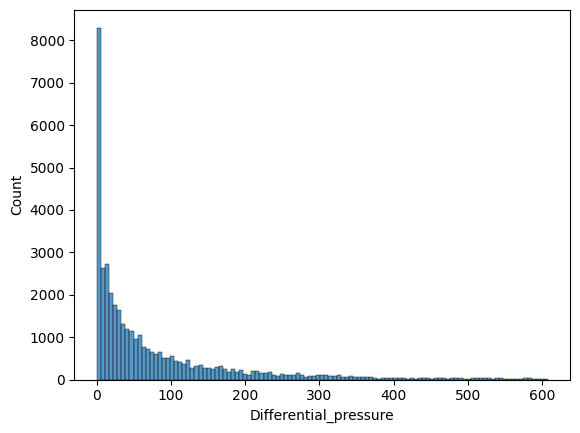

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x = df_train['Differential_pressure'])
plt.show()

A log transformation of this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid.

/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


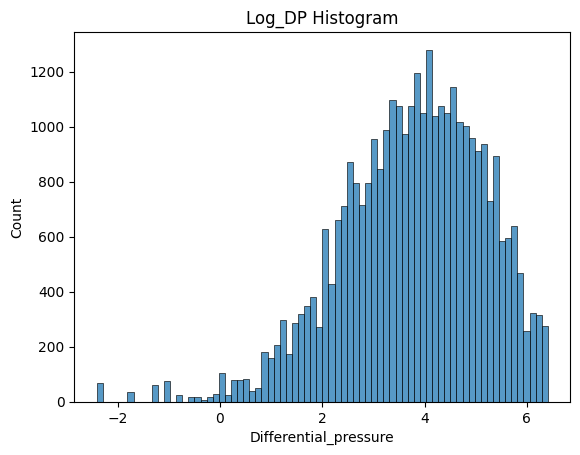

In [6]:
df_train_log = df_train['Differential_pressure']
log_dp = np.log(df_train_log)
# df_train['log_DP'] = log_dp
sns.histplot(x = log_dp)
# sns.boxplot(x = log_dp)
plt.title('Log_DP Histogram')
plt.show()

**Observations** 
* The shape of the numerical differential_pressure data is improved by a natural logarithmic transformation
    * Untreated values of 78.23 mean, std.deviation at 107.34 and median at 35.17, indicates the positively skewed nature of the original data
    * Transformed the data is much improved with mean 3.18 much closer to the median 3.89

The transformed data is still affected by the slight negative skew in the data:
* Pressure measures show unusual behavior at the start of most tests, producing an unusual entry tail of values at zero or below.
    * These can be managed by adding a constant to stop the value becoming negative, or indicate the negative as a missing number or drop the entire observation.
    * Considering these measures indicate a zone at the beginning of the test procedure to 'equalize' the difference in pressure between the areas before and after the filter, we can treat them as outliers and confidently drop the entire row this observation sits in.

### Dropping Outliers
Dropping all negative numbers to reduce the noise of the data

#### Evaluation of detecting outliers using IQR

Old Shape:  (39420, 11)
New Shape:  (29688, 11)


/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


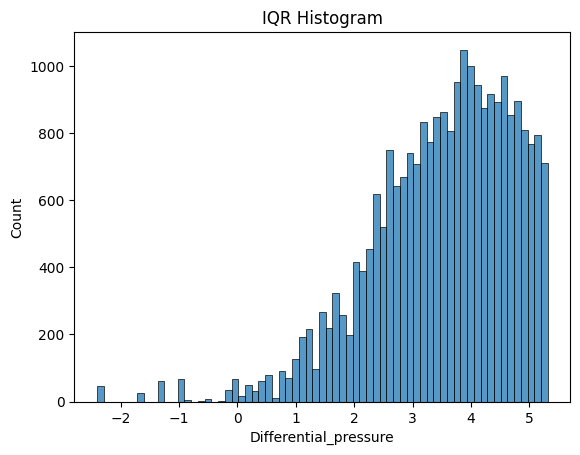

In [7]:
df_train_IQR = df_train.copy()

# IQR
Q1 = np.percentile(df_train_IQR, 25, method='midpoint')
Q3 = np.percentile(df_train_IQR, 75,method='midpoint')
IQR = Q3 - Q1
print("Old Shape: ", df_train_IQR.shape)
 
# Upper bound
upper = np.where(df_train_IQR >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_train_IQR <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df_train_IQR.drop(upper[0], inplace = True)
df_train_IQR.drop(lower[0], inplace = True)
 
print("New Shape: ", df_train_IQR.shape)

df_train_log_IQR = df_train_IQR['Differential_pressure']
log_dp_IQR = np.log(df_train_log_IQR)
# df_train_IQR['log_DP'] = log_dp
sns.histplot(x = log_dp_IQR)
plt.title('IQR Histogram')
plt.show()

IQR transformation is not particularly effective on this data. We can observe that it has made the log data more negatively skewed, in the exact opposite direction we started with. We will not apply this method and proceed with other techniques.

#### The Winsorize Method
Winsorization is the process of replacing the extreme values of statistical data in order to limit the effect of the outliers on the calculations or the results obtained by using that data. To apply this to a our `differential_pressure` variable, where outliers are present only at one end of the data:
* The lower 10% values of the data will have their values set equal to the value of the data point at the 10th percentile.

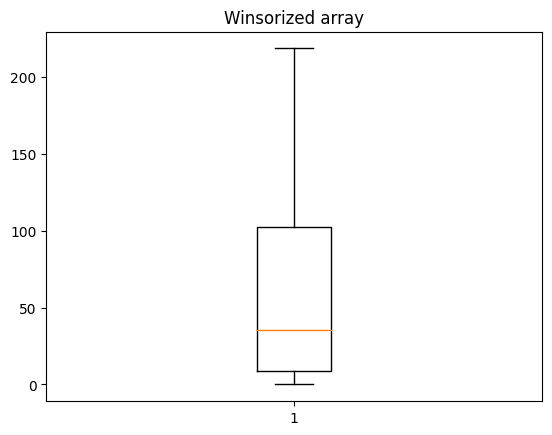

Old Mean:  78.23205031458396
New Mean:  65.76584999494926


In [8]:
from scipy.stats.mstats import winsorize

WinsorizedArrayMean = np.mean(df_train['Differential_pressure'])
df_train['winz_Mean'] = winsorize(df_train['Differential_pressure'],(0.1,0.1))
WinsorizedArray = df_train['winz_Mean']
plt.boxplot(WinsorizedArray)
plt.title('Winsorized array')
plt.show()
WinsorizedArrayNewMean = np.mean(WinsorizedArray)
print('Old Mean: ', WinsorizedArrayMean)
print('New Mean: ', WinsorizedArrayNewMean)

In [9]:
df_train

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,change_DP,Mass_g,Cumulative_Mass_g,Tt,Filter_Balance,winz_Mean
0,1,0.0000,0.000000,0.1,236.428943,1.025,0.0000,0.242340,0.242340,44.9,100.00,0.0000
1,1,0.0000,0.000000,0.2,236.428943,1.025,0.0000,0.242340,0.484679,44.9,100.00,0.0000
2,1,0.0000,0.000000,0.3,236.428943,1.025,0.0000,0.242340,0.727019,44.9,100.00,0.0000
3,1,0.0000,0.000000,0.4,236.428943,1.025,0.0000,0.242340,0.969359,44.9,100.00,0.0000
4,1,0.0000,0.000000,0.5,236.428943,1.025,0.0000,0.242340,1.211698,44.9,100.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
39415,50,359.9718,58.721877,59.4,177.321707,1.200,1.6276,0.212786,126.394913,59.8,40.00,218.7319
39416,50,360.7856,58.699919,59.5,177.321707,1.200,0.8138,0.212786,126.607699,59.8,39.87,218.7319
39417,50,361.5090,58.743820,59.6,177.321707,1.200,0.7234,0.212786,126.820485,59.8,39.75,218.7319
39418,50,362.0515,58.601152,59.7,177.321707,1.200,0.5425,0.212786,127.033271,59.8,39.66,218.7319


### Remove rows with negative numbers

In [10]:
df_train.loc[:,'log_DP'] = log_dp
df_train = df_train[df_train.select_dtypes(include=[np.number]).ge(0).all(1)]
df_train

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,change_DP,Mass_g,Cumulative_Mass_g,Tt,Filter_Balance,winz_Mean,log_DP
53,1,1.537182,51.827014,5.4,236.428943,1.025,1.265915,0.242340,13.086342,44.9,99.74,1.537182,0.429951
54,1,1.537182,54.143527,5.5,236.428943,1.025,0.000000,0.242340,13.328682,44.9,99.74,1.537182,0.429951
55,1,1.537182,54.518255,5.6,236.428943,1.025,0.000000,0.242340,13.571021,44.9,99.74,1.537182,0.429951
56,1,1.537182,54.658781,5.7,236.428943,1.025,0.000000,0.242340,13.813361,44.9,99.74,1.537182,0.429951
57,1,3.345631,54.780562,5.8,236.428943,1.025,1.808449,0.242340,14.055701,44.9,99.44,3.345631,1.207655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39415,50,359.971800,58.721877,59.4,177.321707,1.200,1.627600,0.212786,126.394913,59.8,40.00,218.731900,5.886026
39416,50,360.785600,58.699919,59.5,177.321707,1.200,0.813800,0.212786,126.607699,59.8,39.87,218.731900,5.888284
39417,50,361.509000,58.743820,59.6,177.321707,1.200,0.723400,0.212786,126.820485,59.8,39.75,218.731900,5.890287
39418,50,362.051500,58.601152,59.7,177.321707,1.200,0.542500,0.212786,127.033271,59.8,39.66,218.731900,5.891786


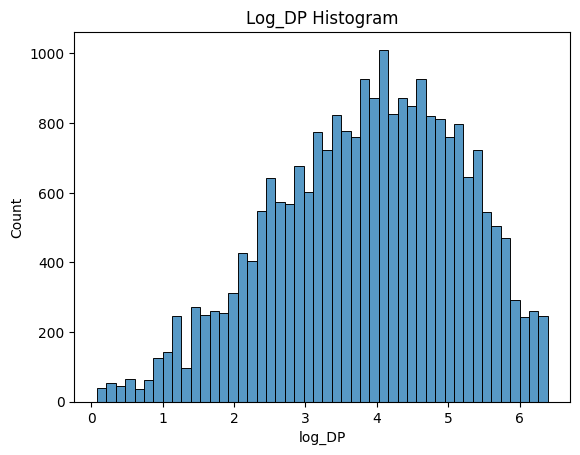

Old Shape:  (39420, 13)
New Shape:  (23964, 13)


In [13]:
old_shape = pd.read_csv(f'outputs/datasets/cleaned/dfCleanTrain.csv')
old_shape['winz_Mean'] = WinsorizedArray
old_shape['log_DP'] = np.log(df_train['Differential_pressure'])
sns.histplot(x = df_train['log_DP'])
plt.title('Log_DP Histogram')
plt.show()
print("Old Shape: ", old_shape.shape)
print("New Shape: ", df_train.shape)

## Smart correlated selection

---

## Save Datasets

Save the files to /transformed folder

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/transformed')
except Exception as e:
  print(e)

df_train.to_csv(f'outputs/datasets/transformed/dfTransformedTrain.csv',index=False)
df_test.to_csv(f'outputs/datasets/transformed/dfTransformedTest.csv',index=False)

---

# Conclusions and Next steps

#### Conclusions: 
* 

#### Next Steps:
* Regression Model
* Classification Model
* Cluster Model
* Correlation Study